In [1]:
import torch
import numpy as np
import  pandas as pd

class DataSet:
    """
    This class is used to create the data to be used in the CCT model
    """
    def __init__(self, fp='C:\Education\MSCS UDC\Research Projects\CCT Project\datasets\Ammonium ACTSOR-AQUA-UDC-1 2017-01-26T01%3A01&to=2017-01-26T12%3A59.json', look_back=5) -> None:
        self.fp = fp # file path
        self.data = self.load_file() 
        self.look_back = look_back
        self.dataset = self.__data() 
        self.X, self.y = self.create_dataset()

    def load_file(self):
        data = pd.read_json(self.fp)
        data['readTime'] = pd.to_datetime(data['readTime'])
        data.set_index('readTime', inplace=True)
        return data


    def __data(self):
        """
        Perfom min-max scaling on the data
        """
        dataset = self.data
        max_value = np.max(dataset['ammonium']) 
        min_value = np.min(dataset['ammonium']) 
        range_val = max_value - min_value
        return list(map(lambda x: x/range_val, dataset['ammonium']))

    def create_dataset(self):
        X, y = [], []
        for i in range(len(self.dataset) - self.look_back): # create sequences with labels.
            a = self.dataset[i:(i+self.look_back)]
            X.append(a)
            y.append(self.dataset[i+self.look_back])
        return np.array(X), np.array(y)

    def perfom_splits(self):
        """
        Create a training and testing split on the data
        """
        train_size = int(len(self.X)*0.9)
        test_size = len(self.X) - train_size
        x_train, y_train = self.X[:train_size], self.y[:train_size]
        x_test, y_test = self.X[train_size:], self.y[train_size:]
        x_train,x_test = torch.from_numpy(x_train.reshape(-1, self.look_back, 1)), \
            torch.from_numpy(x_test.reshape(-1, self.look_back, 1)) 
        y_train, y_test = torch.from_numpy(y_train.reshape(-1, 1, 1)), \
            torch.from_numpy(y_test.reshape(-1, 1, 1))

        assert y_train.size()[0] == x_train.size()[0]
        assert y_train.size()[1:] == y_test.size()[1:]
        assert x_train.size()[1:] == x_test.size()[1:]
        assert y_test.size()[0] == x_test.size()[0]
        return x_train,x_test, y_train, y_test

In [23]:
#!unzip utils
!pip install timm

# Original Code from the SHI-Labs
# .utils in the from lines changed to utils
# .registry import changed to the function def (copied from the registry.py)

from torch.hub import load_state_dict_from_url
import torch.nn as nn
from utils.transformers import TransformerClassifier
from utils.tokenizer import Tokenizer
from utils.helpers import pe_check, fc_check

try:
    from timm.models.registry import register_model
except ImportError:
    #from .registry import register_model
    def register_model(func):
      """
      Fallback wrapper in case timm isn't installed
      """
      return func

model_urls = {
    'cct_7_3x1_32':
        'https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_7_3x1_32_cifar10_300epochs.pth',
    'cct_7_3x1_32_sine':
        'https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_7_3x1_32_sine_cifar10_5000epochs.pth',
    'cct_7_3x1_32_c100':
        'https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_7_3x1_32_cifar100_300epochs.pth',
    'cct_7_3x1_32_sine_c100':
        'https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_7_3x1_32_sine_cifar100_5000epochs.pth',
    'cct_7_7x2_224_sine':
        'https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_7_7x2_224_flowers102.pth',
    'cct_14_7x2_224':
        'https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_14_7x2_224_imagenet.pth',
    'cct_14_7x2_384':
        'https://shi-labs.com/projects/cct/checkpoints/finetuned/cct_14_7x2_384_imagenet.pth',
    'cct_14_7x2_384_fl':
        'https://shi-labs.com/projects/cct/checkpoints/finetuned/cct_14_7x2_384_flowers102.pth',
}


class CCT(nn.Module):
    def __init__(self,
                 sequence_length = 5,
                 embedding_dim=128, # change the value
                 n_input_channels=1, #Two channels for time and data
                 n_conv_layers=1,
                 kernel_size=1,
                 stride=1, #slide the kernel over 1 position
                 padding=0,
                 dropout=0.,
                 attention_dropout=0.1,
                 stochastic_depth=0.1,
                 num_layers=14,
                 num_heads=4,
                 mlp_ratio=4.0,
                 num_classes=1,
                 positional_embedding='learnable',
                 *args, **kwargs):
        super(CCT, self).__init__()

        self.tokenizer = Tokenizer(n_input_channels=self.look_back,
                                   n_output_channels=embedding_dim,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   activation=nn.ReLU,
                                   n_conv_layers=n_conv_layers,
                                   conv_bias=False)

        self.classifier = TransformerClassifier(
            sequence_length=sequence_length,
            embedding_dim=embedding_dim,
            seq_pool=True,
            dropout=dropout,
            attention_dropout=attention_dropout,
            stochastic_depth=stochastic_depth,
            num_layers=num_layers,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            num_classes=num_classes,
            positional_embedding=positional_embedding
        )

    def forward(self, x):
        x = self.tokenizer(x)
        return self.classifier(x)


def _cct(arch, pretrained, progress,
         num_layers, num_heads, mlp_ratio, embedding_dim,
         kernel_size=3, stride=None, padding=None,
         positional_embedding='learnable',
         *args, **kwargs):
    stride = stride if stride is not None else max(1, (kernel_size // 2) - 1)
    padding = padding if padding is not None else max(1, (kernel_size // 2))
    model = CCT(num_layers=num_layers,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                embedding_dim=embedding_dim,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                *args, **kwargs)

    if pretrained:
        if arch in model_urls:
            state_dict = load_state_dict_from_url(model_urls[arch],
                                                  progress=progress)
            if positional_embedding == 'learnable':
                state_dict = pe_check(model, state_dict)
            elif positional_embedding == 'sine':
                state_dict['classifier.positional_emb'] = model.state_dict()['classifier.positional_emb']
            state_dict = fc_check(model, state_dict)
            model.load_state_dict(state_dict)
        else:
            raise RuntimeError(f'Variant {arch} does not yet have pretrained weights.')
    return model

# I don't need anything after all this.

def cct_2(arch, pretrained, progress, *args, **kwargs):
    return _cct(arch, pretrained, progress, num_layers=2, num_heads=2, mlp_ratio=1, embedding_dim=128,
                *args, **kwargs)


def cct_4(arch, pretrained, progress, *args, **kwargs):
    return _cct(arch, pretrained, progress, num_layers=4, num_heads=2, mlp_ratio=1, embedding_dim=128,
                *args, **kwargs)


def cct_6(arch, pretrained, progress, *args, **kwargs):
    return _cct(arch, pretrained, progress, num_layers=6, num_heads=4, mlp_ratio=2, embedding_dim=256,
                *args, **kwargs)


def cct_7(arch, pretrained, progress, *args, **kwargs):
    return _cct(arch, pretrained, progress, num_layers=7, num_heads=4, mlp_ratio=2, embedding_dim=256,
                *args, **kwargs)


def cct_14(arch, pretrained, progress, *args, **kwargs):
    return _cct(arch, pretrained, progress, num_layers=14, num_heads=6, mlp_ratio=3, embedding_dim=384,
                *args, **kwargs)



@register_model
def cct_2_3x2_32(pretrained=False, progress=False,
                 img_size=32, positional_embedding='learnable',
                 *args, **kwargs):
    return cct_2('cct_2_3x2_32', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding
                 *args, **kwargs)


@register_model
def cct_2_3x2_32_sine(pretrained=False, progress=False,
                      img_size=32, positional_embedding='sine', num_classes=10,
                      *args, **kwargs):
    return cct_2('cct_2_3x2_32_sine', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_4_3x2_32(pretrained=False, progress=False,
                 img_size=32, positional_embedding='learnable', num_classes=10,
                 *args, **kwargs):
    return cct_4('cct_4_3x2_32', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_4_3x2_32_sine(pretrained=False, progress=False,
                      img_size=32, positional_embedding='sine', num_classes=10,
                      *args, **kwargs):
    return cct_4('cct_4_3x2_32_sine', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_6_3x1_32(pretrained=False, progress=False,
                 img_size=32, positional_embedding='learnable', num_classes=10,
                 *args, **kwargs):
    return cct_6('cct_6_3x1_32', pretrained, progress,
                 kernel_size=3, n_conv_layers=1,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_6_3x1_32_sine(pretrained=False, progress=False,
                      img_size=32, positional_embedding='sine', num_classes=10,
                      *args, **kwargs):
    return cct_6('cct_6_3x1_32_sine', pretrained, progress,
                 kernel_size=3, n_conv_layers=1,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_6_3x2_32(pretrained=False, progress=False,
                 img_size=32, positional_embedding='learnable', num_classes=10,
                 *args, **kwargs):
    return cct_6('cct_6_3x2_32', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_6_3x2_32_sine(pretrained=False, progress=False,
                      img_size=32, positional_embedding='sine', num_classes=10,
                      *args, **kwargs):
    return cct_6('cct_6_3x2_32_sine', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_3x1_32(pretrained=False, progress=False,
                 img_size=32, positional_embedding='learnable', num_classes=10,
                 *args, **kwargs):
    return cct_7('cct_7_3x1_32', pretrained, progress,
                 kernel_size=3, n_conv_layers=1,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_3x1_32_sine(pretrained=False, progress=False,
                      img_size=32, positional_embedding='sine', num_classes=10,
                      *args, **kwargs):
    return cct_7('cct_7_3x1_32_sine', pretrained, progress,
                 kernel_size=3, n_conv_layers=1,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_3x1_32_c100(pretrained=False, progress=False,
                      img_size=32, positional_embedding='learnable', num_classes=100,
                      *args, **kwargs):
    return cct_7('cct_7_3x1_32_c100', pretrained, progress,
                 kernel_size=3, n_conv_layers=1,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_3x1_32_sine_c100(pretrained=False, progress=False,
                           img_size=32, positional_embedding='sine', num_classes=100,
                           *args, **kwargs):
    return cct_7('cct_7_3x1_32_sine_c100', pretrained, progress,
                 kernel_size=3, n_conv_layers=1,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_3x2_32(pretrained=False, progress=False,
                 img_size=32, positional_embedding='learnable', num_classes=10,
                 *args, **kwargs):
    return cct_7('cct_7_3x2_32', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_3x2_32_sine(pretrained=False, progress=False,
                      img_size=32, positional_embedding='sine', num_classes=10,
                      *args, **kwargs):
    return cct_7('cct_7_3x2_32_sine', pretrained, progress,
                 kernel_size=3, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_7x2_224(pretrained=False, progress=False,
                  img_size=224, positional_embedding='learnable', num_classes=102,
                  *args, **kwargs):
    return cct_7('cct_7_7x2_224', pretrained, progress,
                 kernel_size=7, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_7_7x2_224_sine(pretrained=False, progress=False,
                       img_size=224, positional_embedding='sine', num_classes=102,
                       *args, **kwargs):
    return cct_7('cct_7_7x2_224_sine', pretrained, progress,
                 kernel_size=7, n_conv_layers=2,
                 img_size=img_size, positional_embedding=positional_embedding,
                 num_classes=num_classes,
                 *args, **kwargs)


@register_model
def cct_14_7x2_224(pretrained=False, progress=False,
                   img_size=224, positional_embedding='learnable', num_classes=1000,
                   *args, **kwargs):
    return cct_14('cct_14_7x2_224', pretrained, progress,
                  kernel_size=7, n_conv_layers=2,
                  img_size=img_size, positional_embedding=positional_embedding,
                  num_classes=num_classes,
                  *args, **kwargs)


@register_model
def cct_14_7x2_384(pretrained=False, progress=False,
                   img_size=384, positional_embedding='learnable', num_classes=1000,
                   *args, **kwargs):
    return cct_14('cct_14_7x2_384', pretrained, progress,
                  kernel_size=7, n_conv_layers=2,
                  img_size=img_size, positional_embedding=positional_embedding,
                  num_classes=num_classes,
                  *args, **kwargs)


@register_model
def cct_14_7x2_384_fl(pretrained=False, progress=False,
                      img_size=384, positional_embedding='learnable', num_classes=102,
                      *args, **kwargs):
    return cct_14('cct_14_7x2_384_fl', pretrained, progress,
                  kernel_size=7, n_conv_layers=2,
                  img_size=img_size, positional_embedding=positional_embedding,
                  num_classes=num_classes,
                  *args, **kwargs)

C:\Users\Landry\AppData\Local\Temp\ipykernel_7440\1678359253.py:151: UserWarning: Overwriting cct_2_3x2_32 in registry with __main__.cct_2_3x2_32. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def cct_2_3x2_32(pretrained=False, progress=False,
C:\Users\Landry\AppData\Local\Temp\ipykernel_7440\1678359253.py:161: UserWarning: Overwriting cct_2_3x2_32_sine in registry with __main__.cct_2_3x2_32_sine. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def cct_2_3x2_32_sine(pretrained=False, progress=False,
C:\Users\Landry\AppData\Local\Temp\ipykernel_7440\1678359253.py:172: UserWarning: Overwriting cct_4_3x2_32 in registry with __main__.cct_4_3x2_32. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def cct_4_3x2_32(pretrained=False, progress=False,
C:\Users\Landry\AppData\Local\Temp\ipykernel_7

# Task 1


In [24]:
time_steps = 1
dataset = DataSet()
data_X, data_Y = dataset.X, dataset.y

x_train,x_test, y_train, y_test = dataset.perfom_splits()
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
#x_train = np.reshape(x_train, (len(x_train), time_steps, 1))  
#x_test = np.reshape(x_test, (len(x_test), time_steps, 1)) #Don't need to have a timesteps because that is where the issue might have come from before.
# print(x_train)
#print(y_test)

In [25]:
from torch.utils.data import DataLoader, TensorDataset

x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)

# Create PyTorch TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define batch size
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 5, 1])
Shape of y: torch.Size([64, 1, 1]) torch.float32


In [27]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 5, 1])
Shape of y: torch.Size([64, 1, 1]) torch.float32


In [28]:
x_test.shape

(614, 5, 1)

In [29]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [30]:
model_cct = CCT()
print(model_cct)

AttributeError: 'CCT' object has no attribute 'look_back'

In [21]:
import torch.optim as optim 
criterion = nn.MSELoss()

optimizer = optim.Adam(model_cct.parameters(), lr= 0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model_cct.train()
    total_loss = 0.0

    for X, y in train_dataloader:
        optimizer.zero_grad()

        # Forward pass with input data
        output = model_cct(X)
        print(output.shape)
        print(y.shape)
        # Calculate loss
        loss = criterion(output.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print or log average training loss for the epoch
    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}')

# Optionally, you can evaluate the model on the test set after training
model_cct.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        output = model_cct(X)
        test_loss = criterion(output.squeeze(), y)

    # Print or log test loss
    print(f'Test Loss: {test_loss.item()}')



RuntimeError: Given groups=1, weight of size [128, 1, 1], expected input[64, 5, 1] to have 1 channels, but got 5 channels instead

In [ ]:
#Modified to separate loss function and optimizer for each model

loss_fn_cct = nn.CrossEntropyLoss()
optimizer_cct = torch.optim.SGD(model_cct.parameters(), lr=1e-3)

NameError: name 'model_cct' is not defined

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
#Modified: train&test the CCT model
epochs = 5
model = model_cct
loss_fn = loss_fn_cct
optimizer = optimizer_cct

for t in range(epochs):
    print(f"CCT Model: Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("CCT Done!")

CCT Model: Epoch 1
-------------------------------


RuntimeError: Given groups=1, weight of size [128, 1, 3], expected input[64, 5, 1] to have 1 channels, but got 5 channels instead


[Learn the Basics](intro.html) ||
**Quickstart** ||
[Tensors](tensorqs_tutorial.html) ||
[Datasets & DataLoaders](data_tutorial.html) ||
[Transforms](transforms_tutorial.html) ||
[Build Model](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[Optimization](optimization_tutorial.html) ||
[Save & Load Model](saveloadrun_tutorial.html)

# Quickstart
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

ImportError: cannot import name 'ToTensor' from 'torchvision.transforms' (unknown location)

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [ ]:
# This cell code changed from FashionMNIST to CIFAR10

# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 170498071/170498071 [00:30<00:00, 5594503.52it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).




--------------




## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [ ]:
# The first linear layer input changed from 28*28 to 32*32*3 (due to FashionNNIST to CIFAR10)
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model_linear = NeuralNetwork().to(device)
print(model_linear)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## CCT Model


In [ ]:
import torch
# The first linear layer input changed from 28*28 to 32*32*3 (due to FashionNNIST to CIFAR10)
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

model_cct = cct_2_3x2_32().to(device)
print(model_cct)

NameError: name 'torch' is not defined

Read more about [building neural networks in PyTorch](buildmodel_tutorial.html).




--------------




## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [ ]:
#Modified to separate loss function and optimizer for each model

loss_fn_linear = nn.CrossEntropyLoss()
optimizer_linear = torch.optim.SGD(model_linear.parameters(), lr=1e-3)

loss_fn_cct = nn.CrossEntropyLoss()
optimizer_cct = torch.optim.SGD(model_cct.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
#Modified: train&test the linear model
%%time
epochs = 5
model = model_linear
loss_fn = loss_fn_linear
optimizer = optimizer_linear

for t in range(epochs):
    print(f"Linear Model: Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Linear Done!")

Linear Model: Epoch 1
-------------------------------
loss: 2.300155  [    0/50000]
loss: 2.301221  [ 6400/50000]
loss: 2.292411  [12800/50000]
loss: 2.283465  [19200/50000]
loss: 2.281371  [25600/50000]
loss: 2.273720  [32000/50000]
loss: 2.275151  [38400/50000]
loss: 2.280617  [44800/50000]
Test Error: 
 Accuracy: 16.7%, Avg loss: 2.265975 

Linear Model: Epoch 2
-------------------------------
loss: 2.279969  [    0/50000]
loss: 2.278288  [ 6400/50000]
loss: 2.239245  [12800/50000]
loss: 2.263614  [19200/50000]
loss: 2.238737  [25600/50000]
loss: 2.233803  [32000/50000]
loss: 2.248610  [38400/50000]
loss: 2.239021  [44800/50000]
Test Error: 
 Accuracy: 20.9%, Avg loss: 2.225428 

Linear Model: Epoch 3
-------------------------------
loss: 2.247787  [    0/50000]
loss: 2.241838  [ 6400/50000]
loss: 2.177146  [12800/50000]
loss: 2.233646  [19200/50000]
loss: 2.185372  [25600/50000]
loss: 2.183100  [32000/50000]
loss: 2.220221  [38400/50000]
loss: 2.182153  [44800/50000]
Test Error: 
 

In [ ]:
#Saving the linear model

torch.save(model_linear.state_dict(), "model_linear.pth")
print("Saved the linear model state to model_linear.pth")

torch.save(model_cct.state_dict(), "model_cct.pth")
print("Saved CCT model state to model_cct.pth")

Saved the linear model state to model_linear.pth
Saved CCT model state to model_cct.pth


In [ ]:
#Modified: train&test the CCT model
%%time
epochs = 5
model = model_cct
loss_fn = loss_fn_cct
optimizer = optimizer_cct

for t in range(epochs):
    print(f"CCT Model: Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("CCT Done!")

CCT Model: Epoch 1
-------------------------------
loss: 2.294594  [    0/50000]
loss: 2.299885  [ 6400/50000]
loss: 2.291082  [12800/50000]
loss: 2.301929  [19200/50000]
loss: 2.289249  [25600/50000]
loss: 2.271498  [32000/50000]
loss: 2.271566  [38400/50000]
loss: 2.268686  [44800/50000]
Test Error: 
 Accuracy: 19.6%, Avg loss: 2.258488 

CCT Model: Epoch 2
-------------------------------
loss: 2.274891  [    0/50000]
loss: 2.256397  [ 6400/50000]
loss: 2.221311  [12800/50000]
loss: 2.254772  [19200/50000]
loss: 2.250368  [25600/50000]
loss: 2.204877  [32000/50000]
loss: 2.201191  [38400/50000]
loss: 2.206580  [44800/50000]
Test Error: 
 Accuracy: 22.1%, Avg loss: 2.184597 

CCT Model: Epoch 3
-------------------------------
loss: 2.218835  [    0/50000]
loss: 2.187050  [ 6400/50000]
loss: 2.113835  [12800/50000]
loss: 2.181562  [19200/50000]
loss: 2.195395  [25600/50000]
loss: 2.106834  [32000/50000]
loss: 2.098742  [38400/50000]
loss: 2.109198  [44800/50000]
Test Error: 
 Accuracy:

Read more about [Training your model](optimization_tutorial.html).




In [ ]:
#Saving the CCT model

torch.save(model_cct.state_dict(), "model_cct.pth")
print("Saved CCT model state to model_cct.pth")

Saved CCT model state to model_cct.pth


--------------




## Loading and Using the Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.




In [ ]:
from matplotlib import pyplot as plt

def plot_images(x, y, class_names, x_adv=None, y_adv=None):
    if x_adv is not None:
        fig, ax = plt.subplots(3, 10, figsize=(20, 5))
    else:
        fig, ax = plt.subplots(1, 10, figsize=(20, 5))

    for i in range(len(y)):
        print("i=",i, "y[i]=",y[i])
        if x_adv is not None:
            ax[0, i].imshow(x[i].permute(1, 2, 0))
            ax[0, i].set_title(class_names[y[i]])
            ax[0, i].axis("off")
            ax[1, i].imshow(x_adv[i].detach().cpu().permute(1, 2, 0))
            if y_adv[i].item() != y[i].item():
                ax[1, i].set_title(class_names[y_adv[i]], color="r")
            else:
                ax[1, i].set_title(class_names[y_adv[i]], color="k")
            ax[1, i].axis("off")
            ax[2, i].imshow(
                (torch.abs(x[i] - x_adv[i].detach().cpu()) * 25)
                .clamp_(0, 1)
                .permute(1, 2, 0)
            )
            ax[2, i].axis("off")
        else:
            ax[i].imshow(x[i].permute(1, 2, 0))
            ax[i].set_title(class_names[y[i]])
            ax[i].axis("off")

In [ ]:
#Classes (Lables) changed due to FashionMNIST to CIFAR10
'''
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
'''
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


## Load a model and Predict on a single input

tensor([3])
i= 0 y[i]= tensor(3)
torch.Size([1, 3072])
Predicted: "dog", Actual: "cat"


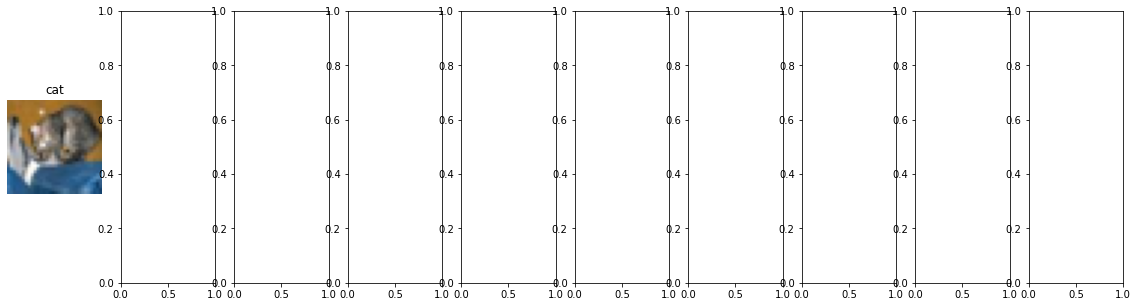

In [ ]:
# This Cell is for the Linear Model

#--- Loading the Model
model = NeuralNetwork()
model.load_state_dict(torch.load("model_linear.pth"))

#--- Prediction using the loaded model
model.eval()
#x, y = test_data[0][0], test_data[0][1]
x, y = test_data[0][0], test_data[0][1]
print(torch.tensor(y)[None])
plot_images(x[None, :], list(torch.tensor(y)[None]), classes)
x = x.view(1, -1) # Use this for the Linear Model to convert [3x32x32] to [1 x (3x32x32)] for the batch dimension
#x=x[None, :] # Use this for the CCT Model to convert [3x32x32] to [1x3x32x32]
print(x.shape)


with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

tensor([3])
i= 0 y[i]= tensor(3)
torch.Size([1, 3, 32, 32])
Predicted: "automobile", Actual: "cat"


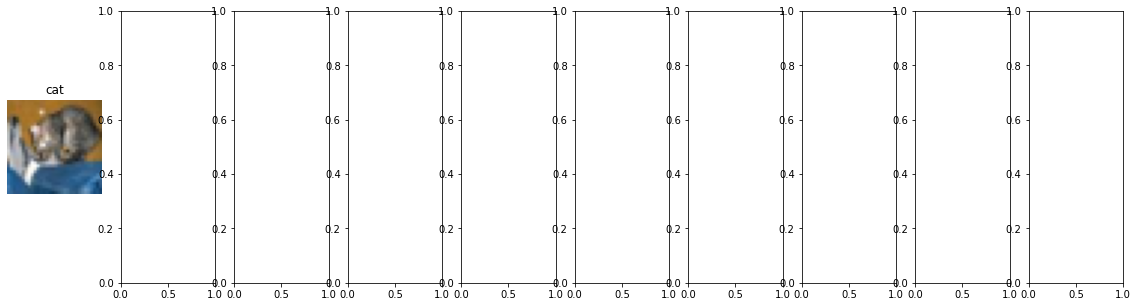

In [ ]:
# This Cell is for the CCT Model

#--- Loading the Model
model = cct_2_3x2_32()
model.load_state_dict(torch.load("model_cct.pth"))

#--- Prediction using the loaded model
model.eval()
#x, y = test_data[0][0], test_data[0][1]
x, y = test_data[0][0], test_data[0][1]
print(torch.tensor(y)[None])
plot_images(x[None, :], list(torch.tensor(y)[None]), classes)
#x = x.view(1, -1) # Use this for the Linear Model to convert [3x32x32] to [1 x (3x32x32)] for the batch dimension
x=x[None, :] # Use this for the CCT Model to convert [3x32x32] to [1x3x32x32]
print(x.shape)


with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Read more about [Saving & Loading your model](saveloadrun_tutorial.html).


